# Assignment-1
## Team: Aditya Ahuja (2020275), Deeptanshu Barman Chowdhuri (2020293)

##  Imports & Dataset

In [1]:
import torch
import requests
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt

c:\Anaconda\envs\amlenv\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# device = "cpu"


In [3]:
Noise_0_dataframe = pd.read_csv("../Data/Assignment1/data_0_noise")
Noise_Low_dataframe = pd.read_csv("../Data/Assignment1/data_Low_noise")
Noise_High_dataframe = pd.read_csv("../Data/Assignment1/data_High_noise")

In [4]:
class_index = list(Noise_0_dataframe["era"].unique())
class_index_noise = list(Noise_Low_dataframe["era"].unique())
class_index_t10v_noise = list(Noise_Low_dataframe["target_10_val"].unique())

def encode(value, class_index = class_index):
    return class_index.index(value)

def encode_noise(value, class_index = class_index_noise):
    return class_index.index(value)

def encode_noise_t10v(value, class_index = class_index_t10v_noise):
    return class_index.index(value)


Noise_0_dataframe["era"] = Noise_0_dataframe["era"].apply(encode)
Noise_Low_dataframe["era"] = Noise_Low_dataframe["era"].apply(encode_noise)
Noise_High_dataframe["era"] = Noise_High_dataframe["era"].apply(encode_noise)
Noise_Low_dataframe["target_10_val"] = Noise_Low_dataframe["target_10_val"].apply(encode_noise_t10v)
Noise_High_dataframe["target_10_val"] = Noise_High_dataframe["target_10_val"].apply(encode_noise_t10v)

## Setting up Dataset & Dataloaders

In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, noise, transform=None, target_transform=None, target=None, drop=None):
        self.dataframe = dataframe
        if drop != None:
            self.X = dataframe.drop(drop, axis=1).values
        else:
            self.X = dataframe.values
        self.y = dataframe[target].values
        self.transform = transform
        self.target_transform = target_transform
        self.noise = noise

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item, label = self.X[idx], self.y[idx]
        return item, label

    def get_noise(self):
        return self.noise

In [6]:
#Setting up datasets
Noise_0_dataset_era = CustomDataset(Noise_0_dataframe, "0",drop = ["row_num","day","era","target_10_val","target_5_val"], target = "era")
Noise_Low_dataset_era = CustomDataset(Noise_Low_dataframe, "Low", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "era")
Noise_High_dataset_era = CustomDataset(Noise_High_dataframe, "High", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "era")
Noise_Low_dataset_t10v = CustomDataset(Noise_Low_dataframe, "Low", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "target_10_val")
Noise_High_dataset_t10v = CustomDataset(Noise_High_dataframe, "High", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "target_10_val")
Noise_0_train_era, Noise_0_test_era = random_split(Noise_0_dataset_era, [int(len(Noise_0_dataset_era)*0.8), int(len(Noise_0_dataset_era)*0.2)])
Noise_Low_train_era, Noise_Low_test_era = random_split(Noise_Low_dataset_era, [int(len(Noise_Low_dataset_era)*0.8), int(len(Noise_Low_dataset_era)*0.2)])
Noise_High_train_era, Noise_High_test_era = random_split(Noise_High_dataset_era, [int(len(Noise_High_dataset_era)*0.8), int(len(Noise_High_dataset_era)*0.2)])
Noise_Low_train_t10v, Noise_Low_test_t10v = random_split(Noise_Low_dataset_t10v, [int(len(Noise_Low_dataset_t10v)*0.8), int(len(Noise_Low_dataset_t10v)*0.2)])
Noise_High_train_t10v, Noise_High_test_t10v = random_split(Noise_High_dataset_t10v, [int(len(Noise_High_dataset_t10v)*0.8), int(len(Noise_High_dataset_t10v)*0.2)])

In [7]:
#Setting up dataloaders
Noise_0_era_train_loader = DataLoader(Noise_0_train_era, batch_size=64, shuffle=True)
Noise_0_era_test_loader = DataLoader(Noise_0_test_era, batch_size=64, shuffle=True)
########################################################################################
Noise_Low_era_train_loader = DataLoader(Noise_Low_train_era, batch_size=64, shuffle=True)
Noise_Low_era_test_loader = DataLoader(Noise_Low_test_era, batch_size=64, shuffle=True)
########################################################################################
Noise_High_era_train_loader = DataLoader(Noise_High_train_era, batch_size=64, shuffle=True)
Noise_High_era_test_loader = DataLoader(Noise_High_test_era, batch_size=64, shuffle=True)
########################################################################################
Noise_Low_t10v_train_loader = DataLoader(Noise_Low_train_t10v, batch_size=512, shuffle=True)
Noise_Low_t10v_test_loader = DataLoader(Noise_Low_test_t10v, batch_size=512, shuffle=True)
########################################################################################
Noise_High_t10v_train_loader = DataLoader(Noise_High_train_t10v, batch_size=512, shuffle=True)
Noise_High_t10v_test_loader = DataLoader(Noise_High_test_t10v, batch_size=512, shuffle=True)
########################################################################################


##  Cascade_Model

In [8]:
class MyMLP(torch.nn.Module):
    def __init__ (self, layers,activation = torch.nn.ReLU(), dropout = 0.5):
        super().__init__()
        linear = [torch.nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]
        self.layers = []
        for i in range(len(linear)):
            if (i == len(linear)-1):
                self.layers.append(linear[i])
            else:
                self.layers.append(linear[i])
                self.layers.append(activation)
                if (dropout!=0): self.layers.append(torch.nn.Dropout(dropout))
        self.layers = torch.nn.Sequential(*self.layers)
        
        self.softmax = torch.nn.LogSoftmax(dim = 1)
        
    def forward(self, X):          
        X = self.layers(X)
        X = self.softmax(X)
        return X 

In [9]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10,verbose=True):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()


In [16]:
def train_cascade(initial_data,initial_label,epochs=3,level=3,impurity=0.5):
    print(type(initial_data),type(initial_label))
    initial_data, initial_label = torch.from_numpy(initial_data).to(device), torch.from_numpy(initial_label).to(device)
    Dataset  = torch.utils.data.TensorDataset(initial_data, initial_label)
    D_loader = DataLoader(Dataset, batch_size=64, shuffle=True)  
    level_conf_pred = []
    Models =[]
    for i in range(level):
        print("Current Level:",i)
        level_model = MyMLP(layers = [24,64,32,12], dropout=0).to(device)
        level_model = level_model.to(device)
        optimizer = torch.optim.Adam(level_model.parameters(), lr=0.01)
        train_model(level_model,torch.nn.NLLLoss(), optimizer,D_loader,D_loader,num_epochs=epochs)
        new_dataset=[]
        new_labelset=[]
        for inputs,labels in D_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
            outputs = level_model(inputs)
            outputs = torch.exp(outputs)
            gini=outputs@outputs.T
            gini=torch.diag(gini)
            gini=1-gini
            for i in range(len(gini)):
                if gini[i]>impurity:
                    new_dataset.append(inputs[i].cpu().detach().numpy())
                    new_labelset.append(labels[i].cpu().detach().numpy())
                else:
                    conf,pred = torch.max(outputs[i], 0)
                    conf = conf.item()
                    pred = pred.item()
                    level_conf_pred.append([conf,pred])
        print("For the next level, the number of samples is:",len(new_dataset))
        new_dataset, new_labelset = torch.from_numpy(np.array(new_dataset)), torch.from_numpy(np.array(new_labelset))
        new_dataset = torch.utils.data.TensorDataset(new_dataset, new_labelset)
        D_loader = DataLoader(new_dataset, batch_size=64, shuffle=True)    
        Models.append(level_model)
    return Models,level_conf_pred

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Current Level: 0
Epoch [1/3], Train Loss: 0.8080, Train Acc: 0.6742, Val Loss: 0.6713, Val Acc: 0.7301
Epoch [2/3], Train Loss: 0.6604, Train Acc: 0.7296, Val Loss: 0.6292, Val Acc: 0.7456
Epoch [3/3], Train Loss: 0.6297, Train Acc: 0.7434, Val Loss: 0.6274, Val Acc: 0.7415


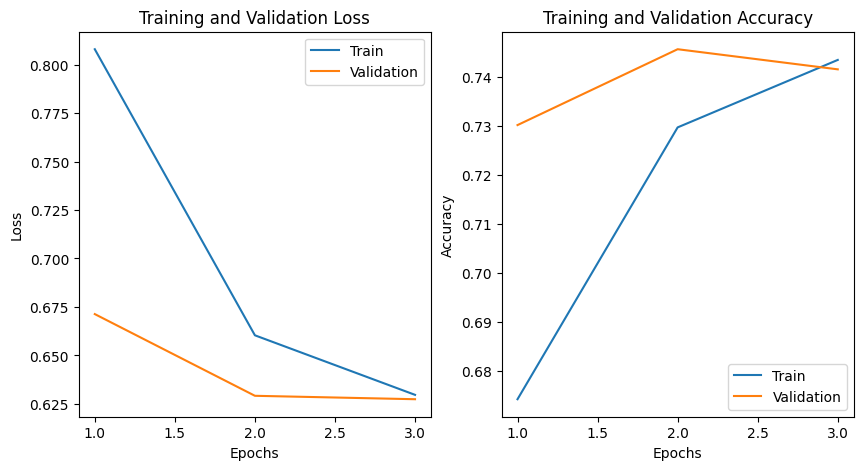

For the next level, the number of samples is: 86908
Current Level: 1
Epoch [1/3], Train Loss: 1.3454, Train Acc: 0.4657, Val Loss: 1.2613, Val Acc: 0.4863
Epoch [2/3], Train Loss: 1.1505, Train Acc: 0.5189, Val Loss: 1.1208, Val Acc: 0.5127
Epoch [3/3], Train Loss: 1.1046, Train Acc: 0.5347, Val Loss: 1.1069, Val Acc: 0.5342


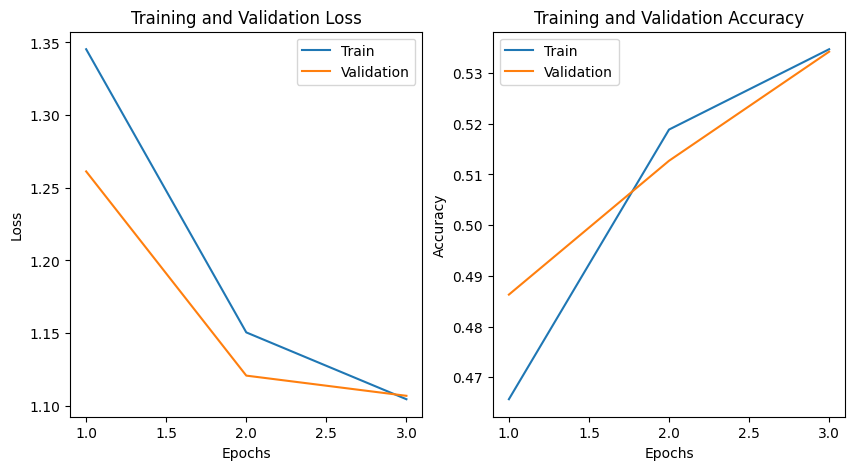

For the next level, the number of samples is: 58251
Current Level: 2
Epoch [1/3], Train Loss: 1.5220, Train Acc: 0.3823, Val Loss: 1.2892, Val Acc: 0.4530
Epoch [2/3], Train Loss: 1.2814, Train Acc: 0.4501, Val Loss: 1.2440, Val Acc: 0.4703
Epoch [3/3], Train Loss: 1.2304, Train Acc: 0.4712, Val Loss: 1.2148, Val Acc: 0.4626


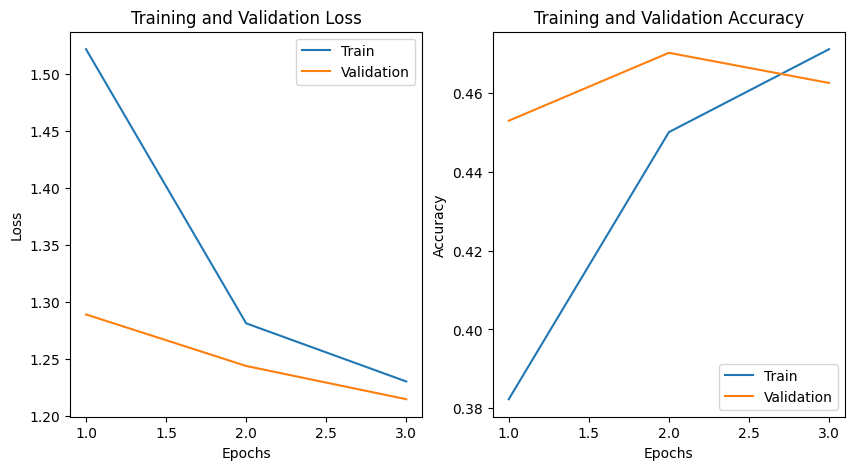

For the next level, the number of samples is: 52930


([MyMLP(
    (layers): Sequential(
      (0): Linear(in_features=24, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=12, bias=True)
    )
    (softmax): LogSoftmax(dim=1)
  ),
  MyMLP(
    (layers): Sequential(
      (0): Linear(in_features=24, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=12, bias=True)
    )
    (softmax): LogSoftmax(dim=1)
  ),
  MyMLP(
    (layers): Sequential(
      (0): Linear(in_features=24, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=12, bias=True)
    )
    (softmax): LogSoftmax(dim=1)
  )],
 [[0.9941076040267944, 8],
  [0.9142069816589355, 7],
  [0.9932854175567627, 5],
  [0.9325938224

In [17]:
train_cascade(Noise_Low_dataframe.iloc[:,:-6].values,Noise_Low_dataframe.loc[:,"era"].values,epochs=3,level=3,impurity=0.5)